In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 


In [3]:
train_data = pd.read_csv(r'C:\Users\kami.cheung\Documents\GitHub\Customer_propensity_to_purchase_dataset\training_sample.csv')
test = pd.read_csv(r'C:\Users\kami.cheung\Documents\GitHub\Customer_propensity_to_purchase_dataset\testing_sample.csv')

In [4]:
train_data.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


In [5]:
print(train_data.shape)
print(test.shape)

(455401, 25)
(151655, 25)


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455401 entries, 0 to 455400
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   455401 non-null  object
 1   basket_icon_click        455401 non-null  int64 
 2   basket_add_list          455401 non-null  int64 
 3   basket_add_detail        455401 non-null  int64 
 4   sort_by                  455401 non-null  int64 
 5   image_picker             455401 non-null  int64 
 6   account_page_click       455401 non-null  int64 
 7   promo_banner_click       455401 non-null  int64 
 8   detail_wishlist_add      455401 non-null  int64 
 9   list_size_dropdown       455401 non-null  int64 
 10  closed_minibasket_click  455401 non-null  int64 
 11  checked_delivery_detail  455401 non-null  int64 
 12  checked_returns_detail   455401 non-null  int64 
 13  sign_in                  455401 non-null  int64 
 14  saw_checkout        

In [7]:
train_data.describe(include='all')

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
count,455401,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,...,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000,455401.000000
unique,455401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,a720-6b732349-a720-4862-bd21-644732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.099150,0.074521,0.112916,0.036849,0.026735,0.003570,0.016208,0.003511,0.230362,...,0.000389,0.005542,0.001096,0.290024,0.680706,0.194220,0.128364,0.534915,0.933224,0.041926
std,NaN,0.298864,0.262617,0.316490,0.188391,0.161307,0.059647,0.126274,0.059151,0.421065,...,0.019711,0.074241,0.033084,0.453773,0.466204,0.395599,0.334495,0.498780,0.249634,0.200420
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000


In [8]:
train_data.nunique()

UserID                     455401
basket_icon_click               2
basket_add_list                 2
basket_add_detail               2
sort_by                         2
image_picker                    2
account_page_click              2
promo_banner_click              2
detail_wishlist_add             2
list_size_dropdown              2
closed_minibasket_click         2
checked_delivery_detail         2
checked_returns_detail          2
sign_in                         2
saw_checkout                    2
saw_sizecharts                  2
saw_delivery                    2
saw_account_upgrade             2
saw_homepage                    2
device_mobile                   2
device_computer                 2
device_tablet                   2
returning_user                  2
loc_uk                          2
ordered                         2
dtype: int64

In [9]:
submission = test[['UserID','ordered']]

In [10]:
train = train_data.sample(frac=8/10,random_state=0)
dev = train_data.drop(train.index)
dev.shape

(91080, 25)

In [11]:
test

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,9d24-25k4-47889d24-25k4-494b-398124,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,7732-1k58-47887732-1k58-4475-679678,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,94k2-632j-471394k2-632j-4b4j-228160,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,jdd8-419d-4714jdd8-419d-4198-674376,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,7473-7595-47147473-7595-4757-227547,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151650,d14b-520k-0j15d14b-520k-4kk2-660471,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,0
151651,d427-5450-0j15d427-5450-4661-370635,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
151652,8869-1022-0j168869-1022-4490-699568,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
151653,5893-2228-0j165893-2228-4kb7-871348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [12]:
train=train.drop(columns=['UserID'])
dev=dev.drop(columns=['UserID'])
test=test.drop(columns=['UserID','ordered'])

In [13]:
X_train = train.iloc[:,:-1].values
X_dev = dev.iloc[:,:-1].values
y_train = train.iloc[:,-1].values
y_actual = dev.iloc[:,-1].values

X_test = test.iloc[:,:].values

C:\Users\kami.cheung\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


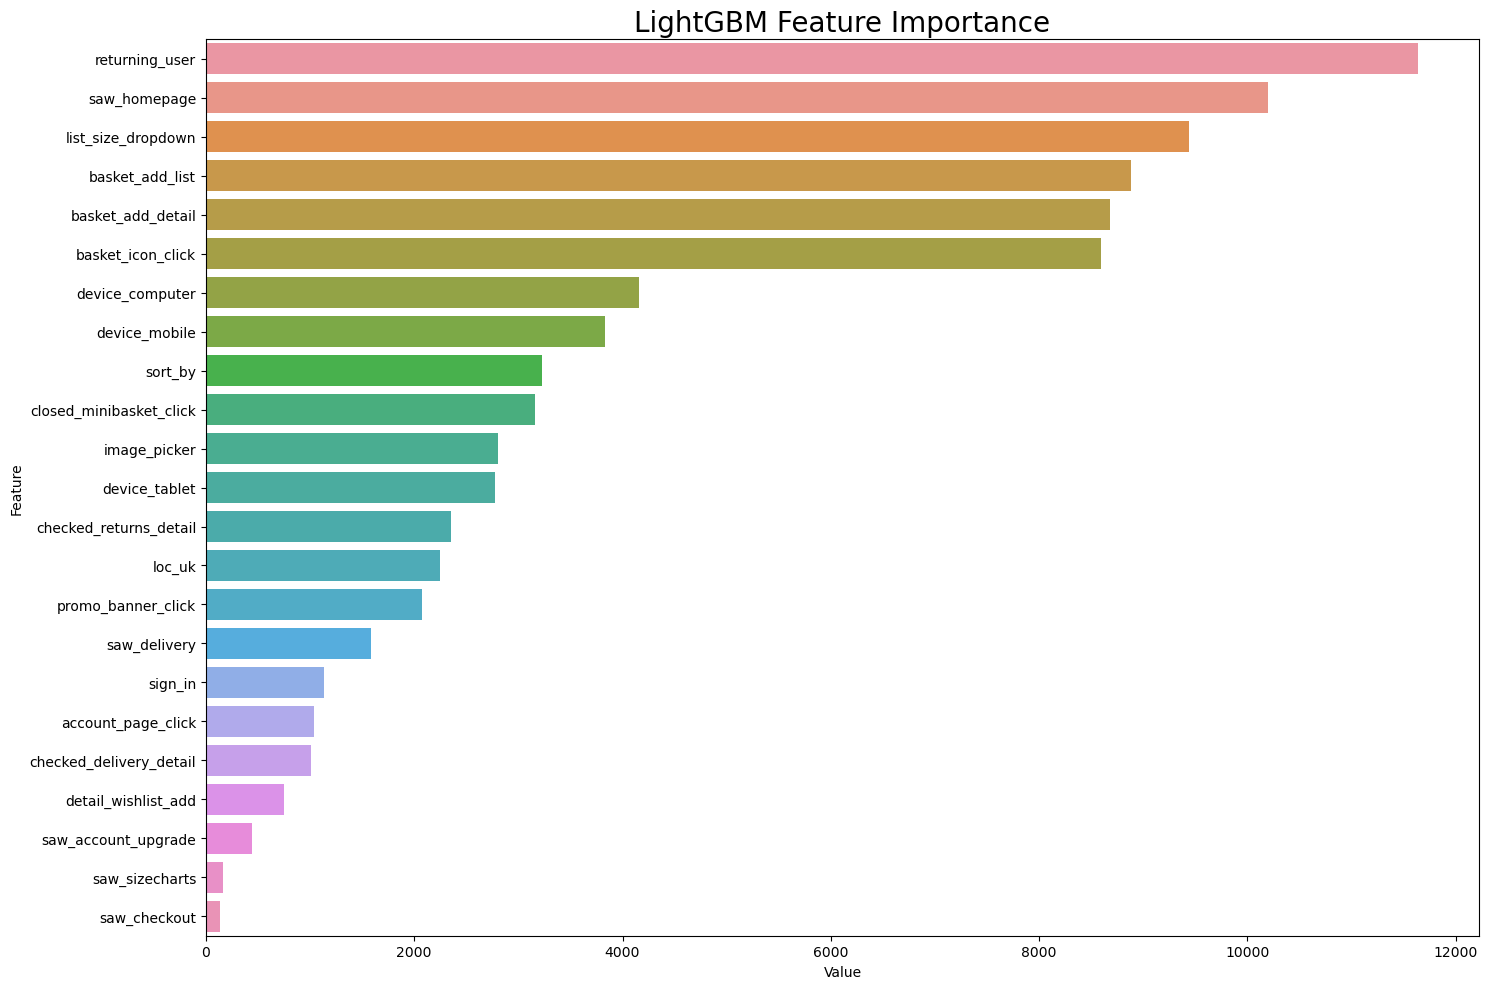

In [14]:
lgb = LGBMClassifier(subsample = 0.5, 
                    num_leaves = 500, num_iterations =200,  random_state=0, learning_rate=0.1)
lgb.fit(X_train, y_train)
y_predicted = lgb.predict(X_dev)
y_predicted

sorted(zip(lgb.feature_importances_, train.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(label= 'LightGBM Feature Importance', size = 20)
plt.tight_layout()
plt.show()

In [15]:
lgb.score(X_dev,y_actual)

0.992610891523935

In [16]:
y_pred=lgb.predict(X_dev)

In [17]:
cm = confusion_matrix(y_actual,y_pred)
cm

array([[86638,   546],
       [  127,  3769]], dtype=int64)

<AxesSubplot:>

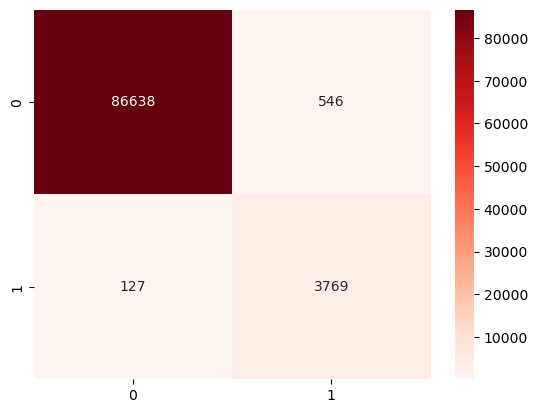

In [18]:
sns.heatmap(cm,annot=True,cmap='Reds', fmt='g')

In [19]:
model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9930939833113747

In [20]:
#model = SVC()
#model.fit(X_train,y_train)
#model.score(X_dev,y_actual)

In [21]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9923913043478261

In [22]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9926657883179623

In [23]:
model = LGBMClassifier()
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9931379007465964

In [24]:
score_table = classification_report(y_actual,y_pred)

In [25]:
print(score_table)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     87184
           1       0.87      0.97      0.92      3896

    accuracy                           0.99     91080
   macro avg       0.94      0.98      0.96     91080
weighted avg       0.99      0.99      0.99     91080



In [26]:
train_data.ordered.value_counts()

0    436308
1     19093
Name: ordered, dtype: int64

In [27]:
(19093/436308)*100

4.37603711139837

- Severely imbalanced datasets, only 4% of training data are users who ordered
- Need to look at different upsampling or downsampling methods to handle imbalance of people who ordered (1).

In [28]:
train.corr()['ordered'].sort_values(ascending=False)

ordered                    1.000000
checked_delivery_detail    0.797823
saw_checkout               0.706829
sign_in                    0.662799
basket_icon_click          0.426312
basket_add_detail          0.413436
basket_add_list            0.290137
saw_homepage               0.156856
list_size_dropdown         0.156587
closed_minibasket_click    0.139618
image_picker               0.070283
returning_user             0.060109
checked_returns_detail     0.059787
account_page_click         0.058537
promo_banner_click         0.055746
sort_by                    0.053336
device_computer            0.049437
loc_uk                     0.031227
saw_delivery               0.030965
saw_account_upgrade        0.025685
detail_wishlist_add        0.023488
device_tablet              0.017256
saw_sizecharts             0.007117
device_mobile             -0.043316
Name: ordered, dtype: float64

We can see that checked out delivery detail, visited checkout page and people who signed in have strong correlation to ordered, however whether users use mobile has low correlation to ordered - so we can remove this column.

In [48]:
model_params = {
    'gaussian_nb': {
        'model': GaussianNB(),
        'params' : {
            'var_smoothing': np.logspace(0,-9, num=100)
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,100,500,1000,5e10],
            'penalty':['l2','l1','elasticnet']
        }
    },
    'lightgbm' : {
        'model': LGBMClassifier(num_leaves = 500, num_iterations =200,  random_state=0),
        'params': {
            'learning_rate': [0.1,0.5,1,5,10]
        }
    }
}

In [49]:
from sklearn.model_selection import GridSearchCV
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.sort_values('best_score',ascending=False)

C:\Users\kami.cheung\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kami.cheung\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kami.cheung\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\kami.cheung\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 457, in _check_solver
 

,model,best_score,best_params
2,logistic_regression,0.993163,"{'C': 1, 'penalty': 'l2'}"
1,random_forest,0.992701,{'n_estimators': 10}
3,lightgbm,0.992644,{'learning_rate': 0.1}
0,gaussian_nb,0.989199,{'var_smoothing': 0.0006579332246575676}


In [50]:
model=LogisticRegression(C=1,penalty='l2')
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9930939833113747

In [74]:
model=LogisticRegression(C=0.01,penalty='l2')
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9929402722880983

In [91]:
model=LogisticRegression(solver='sag',C=5e10,penalty='l2')
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9930939833113747

Tried tuning the regularization strength to a very small amount so as to balance out the strong regularization from default setting of LogisticRegression model C=1.0. As we can see the score actually lowers a little when the strength is strong C=0.01. We have 21 predictors, it might help to reduce some noise - but in the case the strong regularization made the score lower. I used sag solver due to a large dataset.

In [88]:
model=LogisticRegression()
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [51]:
model=GaussianNB(var_smoothing= 0.0006579332246575676)
model.fit(X_train,y_train)
model.score(X_dev,y_actual)

0.9892512077294686

In [96]:
# Drop columns with low correlation
predictors = train_data.drop(['ordered','UserID','device_mobile'], axis=1)
# predictors = train[['checked_delivery_pdp', 'basket_icon_click', 'sign_in', 'saw_checkout']]
targets = train_data.ordered

In [100]:
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=.3)

print("Predictor - Training: ", X_train.shape, "Predictor - Testing:", X_test.shape )

Predictor - Training:  (318780, 22) Predictor - Testing: (136621, 22)


In [104]:
model=LogisticRegression(solver='sag',C=5e10,penalty='l2')
model=model.fit(X_train,y_train)

predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print()
print(classification_report(y_test,predictions))

[[130006    816]
 [    76   5723]]

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    130822
           1       0.88      0.99      0.93      5799

    accuracy                           0.99    136621
   macro avg       0.94      0.99      0.96    136621
weighted avg       0.99      0.99      0.99    136621



Now to predict on the previous days visitors!
#### Start by loading in our sample data of the previous days visitors who did not order.

In [52]:
yesterdays_prospects = pd.read_csv(r'C:\Users\kami.cheung\Documents\GitHub\Customer_propensity_to_purchase_dataset\testing_sample.csv')

In [53]:
yesterdays_prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151655 entries, 0 to 151654
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   151655 non-null  object
 1   basket_icon_click        151655 non-null  int64 
 2   basket_add_list          151655 non-null  int64 
 3   basket_add_detail        151655 non-null  int64 
 4   sort_by                  151655 non-null  int64 
 5   image_picker             151655 non-null  int64 
 6   account_page_click       151655 non-null  int64 
 7   promo_banner_click       151655 non-null  int64 
 8   detail_wishlist_add      151655 non-null  int64 
 9   list_size_dropdown       151655 non-null  int64 
 10  closed_minibasket_click  151655 non-null  int64 
 11  checked_delivery_detail  151655 non-null  int64 
 12  checked_returns_detail   151655 non-null  int64 
 13  sign_in                  151655 non-null  int64 
 14  saw_checkout        

We're going to drop UserID before we predict on this data, so that is matches our training set, but before we do let's pop it into another variable, so we can pull back this identifier later. Once that's done we can drop our unwanted fields and print the head() to check our data

In [54]:
userids = yesterdays_prospects.UserID

yesterdays_prospects = yesterdays_prospects.drop(columns=['UserID','ordered','device_mobile'],axis=1)

yesterdays_prospects.head()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [89]:
yesterdays_prospects.shape

(151655, 22)

Now we'll run our predictions on the best performing and tuned model, and insert them into a field called 'propensity', print the head

In [105]:
model=LogisticRegression(solver='sag',C=5e10,penalty='l2')
model.fit(X_train,y_train)
yesterdays_prospects['propensity']=model.predict_proba(yesterdays_prospects)[:,1]

yesterdays_prospects.head()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk,propensity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.701212e-10
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.701212e-10
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.701212e-10
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.145947e-09
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6.701212e-10


In [132]:
pd.DataFrame(userids)
results = pd.concat([userids, yesterdays_prospects], axis=1)

In [133]:
print(results[['UserID','propensity']].sort_values('propensity',ascending=False).head(20))

                                     UserID  propensity
61686   62d7-k40b-86b462d7-k40b-4d79-325833    0.989797
19282   7d4k-5058-46bk7d4k-5058-4j5b-892506    0.980107
30932    4jk6-b11k-dk774jk6-b11k-4825-64817    0.979260
22137   0071-474d-k7740071-474d-40d7-136068    0.966528
9807    d7d3-7k0b-77b3d7d3-7k0b-4d7j-277864    0.963592
52271   kd4d-437d-j4dbkd4d-437d-4k64-689351    0.962486
32662   5143-72kd-d4535143-72kd-40j8-689442    0.961988
25483   7jk7-9842-d3b77jk7-9842-45b3-929164    0.960816
47568   k36b-3736-9d6jk36b-3736-4414-924963    0.957744
60361   747k-d723-b145747k-d723-4bb7-708577    0.957744
97730   j8d4-7250-6640j8d4-7250-4kd7-948890    0.957371
101194  k45d-7k17-6k74k45d-7k17-4064-526618    0.957336
128454  k787-1450-37dbk787-1450-4318-853205    0.957336
118877  bdkd-4jk6-244bbdkd-4jk6-4j54-600198    0.957336
73743   k34d-151j-9j89k34d-151j-4bbk-290563    0.956600
111651   d980-dk63-50b3d980-dk63-4b90-39923    0.954463
52876   40k0-0327-j5k740k0-0327-47b7-786100    0

In [124]:
results.sort_values('propensity',ascending=False).head(20)

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk,propensity
61686,62d7-k40b-86b462d7-k40b-4d79-325833,1,0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0.991337
30932,4jk6-b11k-dk774jk6-b11k-4825-64817,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0.982682
19282,7d4k-5058-46bk7d4k-5058-4j5b-892506,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0.982216
22137,0071-474d-k7740071-474d-40d7-136068,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0.969968
32662,5143-72kd-d4535143-72kd-40j8-689442,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0.965708
9807,d7d3-7k0b-77b3d7d3-7k0b-4d7j-277864,1,1,1,0,1,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0.959989
47568,k36b-3736-9d6jk36b-3736-4414-924963,1,1,1,1,0,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0.959906
60361,747k-d723-b145747k-d723-4bb7-708577,1,1,1,1,0,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0.959906
25483,7jk7-9842-d3b77jk7-9842-45b3-929164,1,1,1,0,0,0,0,0,1,...,1,0,0,0,1,0,1,1,1,0.959544
97730,j8d4-7250-6640j8d4-7250-4kd7-948890,1,0,1,0,0,0,0,0,1,...,1,0,0,0,1,1,1,1,1,0.958598


## GaussianNB model

In [134]:
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=.3)

print("Predictor - Training: ", X_train.shape, "Predictor - Testing:", X_test.shape )

Predictor - Training:  (318780, 22) Predictor - Testing: (136621, 22)


In [135]:
model=GaussianNB(var_smoothing= 0.0006579332246575676)
model=model.fit(X_train,y_train)

predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print()
print(classification_report(y_test,predictions))

[[129452   1445]
 [    72   5652]]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    130897
           1       0.80      0.99      0.88      5724

    accuracy                           0.99    136621
   macro avg       0.90      0.99      0.94    136621
weighted avg       0.99      0.99      0.99    136621



In [136]:
yesterdays_prospects = pd.read_csv(r'C:\Users\kami.cheung\Documents\GitHub\Customer_propensity_to_purchase_dataset\testing_sample.csv')

userids = yesterdays_prospects.UserID

yesterdays_prospects = yesterdays_prospects.drop(columns=['UserID','ordered','device_mobile'],axis=1)

yesterdays_prospects.head()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [137]:
model=LogisticRegression(solver='sag',C=5e10,penalty='l2')
model.fit(X_train,y_train)
yesterdays_prospects['propensity']=model.predict_proba(yesterdays_prospects)[:,1]

yesterdays_prospects.head()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk,propensity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.771725e-13
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.771725e-13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.771725e-13
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8.101757e-13
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.771725e-13


In [138]:
print(results[['UserID','propensity']].sort_values('propensity',ascending=False).head(20))

                                     UserID  propensity
61686   62d7-k40b-86b462d7-k40b-4d79-325833    0.989797
19282   7d4k-5058-46bk7d4k-5058-4j5b-892506    0.980107
30932    4jk6-b11k-dk774jk6-b11k-4825-64817    0.979260
22137   0071-474d-k7740071-474d-40d7-136068    0.966528
9807    d7d3-7k0b-77b3d7d3-7k0b-4d7j-277864    0.963592
52271   kd4d-437d-j4dbkd4d-437d-4k64-689351    0.962486
32662   5143-72kd-d4535143-72kd-40j8-689442    0.961988
25483   7jk7-9842-d3b77jk7-9842-45b3-929164    0.960816
47568   k36b-3736-9d6jk36b-3736-4414-924963    0.957744
60361   747k-d723-b145747k-d723-4bb7-708577    0.957744
97730   j8d4-7250-6640j8d4-7250-4kd7-948890    0.957371
101194  k45d-7k17-6k74k45d-7k17-4064-526618    0.957336
128454  k787-1450-37dbk787-1450-4318-853205    0.957336
118877  bdkd-4jk6-244bbdkd-4jk6-4j54-600198    0.957336
73743   k34d-151j-9j89k34d-151j-4bbk-290563    0.956600
111651   d980-dk63-50b3d980-dk63-4b90-39923    0.954463
52876   40k0-0327-j5k740k0-0327-47b7-786100    0

In [141]:
results.sort_values('propensity',ascending=False).head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk,propensity
61686,62d7-k40b-86b462d7-k40b-4d79-325833,1,0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0.989797
19282,7d4k-5058-46bk7d4k-5058-4j5b-892506,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0.980107
30932,4jk6-b11k-dk774jk6-b11k-4825-64817,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0.979260
22137,0071-474d-k7740071-474d-40d7-136068,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0.966528
9807,d7d3-7k0b-77b3d7d3-7k0b-4d7j-277864,1,1,1,0,1,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0.963592


Both models have high score of >99%, however Logistic regression achieved a higher f1 score of 93% and a softer regularization strength vs GaussianNB at 88%.